# Make a dataset from custom data formats
If your data is readable by the GUI, you only need to convert annotations. You can then load both into the GUI and export to data and annotations for DAS.

Three alternatives:

### 1. Export your data as wav/npz and csv to a folder and make a dataset with the GUI
`data` folder with `*.wav` or `npz` files files with the recording and matching `*_annotations.csv` files with the annotations (see format details [here]](/technical/data_formats))- recordings and annotations will be matched according to the file base name:
```shell
data\
    file01.wav
    file01_annotations.csv
    another_file.wav
    another_file_annotations.csv
    yaf.wav
    yaf_annotations.csv
```

Simplest way - no need of having to deal with specific of the data structure required by DAS for training - simply hit _DAS/Make dataset for training_ and select the folder.

### 2. Use notebook with custom loaders to directly read recordings and annotations
Intermediate simplicity and flexibility) Folder with the data and annotations in a custom format - provide custom functions for loading audio data and annotations. This is illustrated in the next section.

### 3. DIY dataset
Complex, maximally flexible) Bring your own mappable (for experts): Generate the data structure yourself. The description of the [dataset structure](/technical/data_formats) has information on how to do that.

## Use notebook with custom loaders to directly read recordings and annotations
This notebook creates an annotated data set for training das from lists of filenames for the song recordings and associated annotations.

This may look a bit complicated at first sight but only requires you to change two things in the next two cells:

1. The functions for loading the data (song recordings) and the annotations need to be adapted to work with your data.
2. Two lists with the names of data files (consumed by `load_data`) and the associated annotation files (consumed by `load_annotation`) need to be created.

The notebook works with a small toy data set (with song recordings from the data provided with [Stern (2014)](https://www.janelia.org/lab/stern-lab/tools-reagents-data)) and with annotations produced by [Murthylab_FlySongSegmenter](https://github.com/murthylab/MurthyLab_FlySongSegmenter).

__Note:__ For this tutorial to work, you first need to download some data and example models (266MB) from [here](https://www.dropbox.com/sh/wnj3389k8ei8i1c/AACy7apWxW87IS_fBjI8-7WDa?dl=0) and put the four folders in the `tutorials` folder.

## Internals
The dataset is created in two steps. 

First, the data and annotations for different recordings are combined in a large matrix. This works even with large datasets that don't fit in memory thanks to [zarr](https://zarr.readthedocs.io/en/stable/tutorial.html#storage-alternatives), which provides an interface for on-disk arrays. The annotations are converted from lists of event times to one-hot-encoded probability vectors, (0 for no event, 1 for a specified short duration (default is $\pm$30 samples) surrounding the event).

Second, the zarr dataset is converted to a directory hierarchy of numpy files (npy) using `das.npy_dir_save`. Numpy files allow extremely fast memory mapping, providing faster out-of-memory access than zarr during training. 

Code below closely follows the code used in the GUI - see the [source](https://github.com/janclemenslab/xarray-behave/blob/master/src/xarray_behave/gui/DAS.py) code.

In [1]:
import numpy as np
import zarr
import logging
import das.npy_dir
import das.make_dataset
import das.annot
from glob import glob
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from typing import Tuple, Optional

plt.style.use('ncb.mplstyle')

## Define custom audio and annotation loaders

If your recordings and annotations are not in the format expected by the standard loaders used above (`scipy.io.wavefile.read` for the recordings, `pd.read_csv` with name/start_seconds/stop_seconds for annotations), or if it's hard to convert your data into these standard formats, you can provide your own loaders as long as they conform to the following interface:

- _data loaders_: `samplerate, data = data_loader(filename)`, accepts a single string argument - the path to the data file and returns two things: the samplerate of the data and a numpy array with the recording data [time, channels]. Note: `scipy.io.wavefile.read` returns `[time,]` arrays - you need to add a new axis to make it 2d!
- _annotation loaders_: `df = annotation_loader(filename)`, accepts a single string argument with the file path and returns a pandas DataFrame with these three columns: `name`, `start_seconds`, `stop_seconds` (see 1).

Below, we read example data produced in matlab (D. Stern). The recording was exported and saved as a matlab struct - the audio data is found in `data`, the samplerate is not saved with the data. The annotations were produced by the [Murthylab_FlySongSegmenter](https://github.com/murthylab/MurthyLab_FlySongSegmenter) and the pulse times (in samples) and a mask indicating for each sample in the recording whether it was occupied by noise (0), a pulse train (1), or sine song (2) were exported saved as a struct - `annotations.mask`, `annotations.pulsesamples`.


In [2]:

def data_loader(filename: str, dataset: Optional[str] = None) -> Tuple[float, np.ndarray]:
    with h5py.File(filename, mode='r') as f:    
        data = f['data'][:]
    samplerate = 10_000
    return samplerate, data

def annotation_loader(filename: str) -> pd.DataFrame:
    samplerate = 10_000
    with h5py.File(filename, 'r') as f:
        # fss saves mask with sine=1, pulsetrains=2
        sine = (f['annotations']['mask'][0, :] == 2).astype(np.float)
        sine_onsets = np.where(np.diff(sine) == 1)[0] / samplerate
        sine_offsets = np.where(np.diff(sine) == -1)[0] / samplerate
        
        # fss saves pulse times in samples
        pulse_times = f['annotations']['pulsesamples'][0] / samplerate

    # make lists:
    names = []
    start_seconds = []
    stop_seconds = []

    for pulse_time in pulse_times:
        names.append('pulse')
        start_seconds.append(float(pulse_time))
        stop_seconds.append(float(pulse_time))

    for sine_onset, sine_offset in zip(sine_onsets, sine_offsets):        
        names.append('sine')
        start_seconds.append(float(sine_onset))
        stop_seconds.append(float(sine_offset))

    event_times = das.annot.Events.from_lists(names, start_seconds, stop_seconds)
    df = event_times.to_df()
    return df


## Lists the names of data and annotation files
Lists of `data_files` and associated `annotation_files` are consumed by `load_data` and `load_annotation`, respectively.

In [5]:
# data_dir = '/Users/clemens10/Dropbox/code.py/DAS/tutorials/dat.mat/'
data_dir = '../data/'
files_data = glob(data_dir + '*_recording.mat')  # list all data files
files_annotation = [file.replace('_recording.mat', '_song.mat') for file in files_data]  # generate the names of associated annotation files
[print(f'data "{d}" with annotations in "{a}".') for d, a in zip(files_data, files_annotation)];

data "../data/PS_20130625155828_ch7_recording.mat" with annotations in "../data/PS_20130625155828_ch7_song.mat".
data "../data/PS_20130625111709_ch10_recording.mat" with annotations in "../data/PS_20130625111709_ch10_song.mat".
data "../data/PS_20130628144304_ch15_recording.mat" with annotations in "../data/PS_20130628144304_ch15_song.mat".
data "../data/PS_20130625155828_ch11_recording.mat" with annotations in "../data/PS_20130625155828_ch11_song.mat".


### Test loaders

In [7]:
samplerate, data = data_loader(files_data[0])
print(f"Audio data with samplerate {samplerate}, shape {data.shape}, and data type {data.dtype}")
print('Annotations')
df = annotation_loader(files_annotation[0])
df

Audio data with samplerate 10000, shape (4100001, 1), and data type float32
Annotations


,name,start_seconds,stop_seconds
0,sine,5.1539,5.3898
1,sine,127.9297,128.8389
2,sine,171.8631,172.0899
3,sine,178.0876,178.2290
4,sine,181.9101,182.4161
...,...,...,...
1956,pulse,404.4817,404.4817
1957,pulse,404.5128,404.5128
1958,pulse,404.5440,404.5440
1959,pulse,404.5751,404.5751


In [8]:
for file_data in files_data:
    samplerate, data = data_loader(file_data)
    with h5py.File(file_data + '.h5', 'w') as f:
        f['data'] = data

### Parse annotation files to identify song types
This will collect all unique values in `names` of the annotation files and infer their categories based on the equality of start_seconds and stop_seconds. Skip this step and define `class_names` and `class_categories` manually if you know the song types and their categories.

In [9]:
# go through all annotation files and collect info on classes
class_names = []
class_categories = []
for file_annotation in files_annotation:
    print(file_annotation)
    df = annotation_loader(file_annotation)
    event_times = das.annot.Events.from_df(df)
    class_names.extend(event_times.names)
    class_categories.extend(event_times.categories.values())

class_names, first_indices = np.unique(class_names, return_index=True)
class_categories = list(np.array(class_categories)[first_indices])
class_names = list(class_names)

for class_name, class_category in zip(class_names, class_categories):
    print(f'found {class_name} of type {class_category}')

# Need to add a "noise" song type for when there is no song
class_names.insert(0, 'noise')
class_categories.insert(0, 'segment')

../data/PS_20130625155828_ch7_song.mat
../data/PS_20130625111709_ch10_song.mat
../data/PS_20130628144304_ch15_song.mat
../data/PS_20130625155828_ch11_song.mat
found pulse of type event
found sine of type segment


## Split files into train/val/test sets
Split the list of recordings into train/val/test files:
- `train` is used for optimizing the parameters during model fitting
- `val` is used during training to track model performance and save the current best model based on the performance on the validation data
- `test` is used to evaluate the best model after training is done and fine tune inference

In [10]:
np.random.seed(1)  # seed random number generator for reproducible splits
test_idx, val_idx, train_idx = np.split(np.random.permutation(len(files_data)), (1, 2))  # this will split the recordings into one for testing, one for validation, and the remained for training  
print('Indices of test file(s):', test_idx, '\nindices of validation file(s):', val_idx, '\nindices of train files:', train_idx)

Indices of test file(s): [3] 
indices of validation file(s): [2] 
indices of train files: [0 1]


## Initialize the data structure (store)
The store will hold the audio data and the annotations in a format ready for training (see [here](/technical/data_formats) for details). The store also contains metadata which is important for training and inference:
- samplerates of the data in Hz
- description of the different classes (names, types (segment or events)) - largely used to post-process the output of the network after inference (e.g. detect event times from the probabilities produced by the network).

We use zarr as a data structure because it provides in-memory as well as out-of-memory arrays with the same, dict-like interface (similar to h5py).

Choose the zarr `store_type` based on the total size of your dataset:
- If it fits in memory, use a `DictStore`, which will place the data and annotation arrays in memory. 
- For "big data", use a `DirectoryStore`, this will place the arrays in chunked files in a directory.



In [11]:
samplerate = 10_000  # this is the sample rate of your data and the pulse times
store = das.make_dataset.init_store(
        nb_channels=1,  # number of channels/microphones in the recording
        nb_classes=len(class_names),  # number of classes to predict - [noise, pulse]
        make_single_class_datasets=True,  # also make y_pulse and y_sine
        samplerate=samplerate,  # make sure audio data and the annotations are all on the same sampling rate
        class_names=class_names,
        class_types=class_categories,
        store_type=zarr.DictStore,  # use DirectoryStore for big data        
        store_name='intermediate.zarr', # only used with DirectoryStore - this is the path to the directory created
        )

### Load the individual data files


In [12]:
print(f"Assembling data set:")
for idx, (data_file, annotation_file) in enumerate(zip(files_data, files_annotation)):
    # Determine whether file is test/val/train
    if idx in test_idx:
        target = 'test'
    elif idx in val_idx:
        target = 'val'
    elif idx in train_idx:
        target = 'train'
    else:
        continue

    print(f"   {data_file} -> {target} set")
    fs, x = data_loader(data_file)
    nb_samples = x.shape[0]

    # load annotations
    df = annotation_loader(annotation_file)
    df = df.dropna()

    # make initial annotation matrix
    y = das.make_dataset.make_annotation_matrix(df, nb_samples, fs, class_names)
    
    # blur events
    for class_index, class_category in enumerate(class_categories):
        if class_category == 'event':
            y[:, class_index] = das.make_dataset.blur_events(y[:, class_index],
                                                             event_std_seconds=.0016,
                                                             samplerate=samplerate)
    
    # Append the recording (x) and the prediction target (y) to the data set
    store[target]['x'].append(x)
    store[target]['y'].append(das.make_dataset.normalize_probabilities(y))

    # Make prediction targets for individual song types
    for cnt, class_name in enumerate(class_names[1:]):
        store[target][f'y_{class_name}'].append(das.make_dataset.normalize_probabilities(y[:, [0, cnt+1]]))

print(f"Got {store['train']['x'].shape}, {store['val']['x'].shape}, {store['test']['x'].shape} train/test/val samples.")


Assembling data set:
   ../data/PS_20130625155828_ch7_recording.mat -> train set
   ../data/PS_20130625111709_ch10_recording.mat -> train set
   ../data/PS_20130628144304_ch15_recording.mat -> val set
   ../data/PS_20130625155828_ch11_recording.mat -> test set
Got (8090002, 1), (4150001, 1), (4000001, 1) train/test/val samples.


### Inspect the dataset
Plot x/y values from the dataset to make sure everything is well aligned.

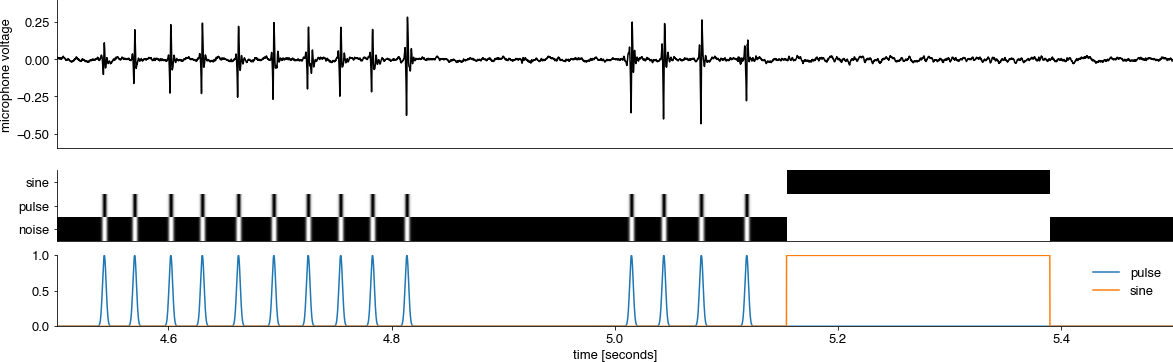

In [13]:
class_names = store.attrs['class_names']
for t0 in [45_000]:  #range(0, 500_000, 10_000):
    t1 = t0 + 10_000
    plt.gcf().set_size_inches(20, 6)
    T = np.arange(t0, t1) / store.attrs['samplerate_x_Hz']
    plt.subplot(211)
    plt.plot(T, store['train']['x'][t0:t1], 'k')
    plt.xticks([])
    plt.ylabel('microphone voltage')
    plt.xlim(min(T), max(T))    

    plt.subplot(413)
    plt.imshow(store['train']['y'][t0:t1, :].astype(np.float).T, cmap='Greys')
    plt.yticks(range(len(class_names)), labels=class_names)
    plt.xticks([])

    plt.subplot(414)                      
    plt.plot(T, store['train']['y'][t0:t1, 1:])
    plt.xlabel('time [seconds]')
    plt.xlim(min(T), max(T))
    plt.legend(class_names[1:])
    plt.show()

### Save as npy_dir
Once all data and annotation files have been appended to the store, save the data as an `npy_dir` store - a directory hierarchy that replicates the nested dictionary structure of the zarr store. For instance, the data set at `root['train']['x']` (the audio data for training) will be stored as `store_name/train/x.npy`. We use these npy files rather than the zarr store because access is faster. Saving is done by `das.npy_dir_save`. The directory structure is mapped back to a nested dictionary via `das.npy_dir.load`. If you used the `DirectoryStore` during assembly, you can delete the `*.zarr` directory after that final step.

In [14]:
# Save the zarr store as a hierarchy of npy files
store_folder = 'tutorial_dataset.npy'
logging.info(f'  Saving to {store_folder}.')
das.npy_dir.save(store_folder, store)

You can now train using the [GUI](/tutorials_gui/train), or a [script](/tutorials/train), or the [command line](/tutorials/train).